## 2 - Conducting the experiment from different availability zones in the Singapore region

Improving from our previous design where we conducted the experiment from our local machine, we can repeat this experiment by running them in three separate EC2 instances each launched in a different availability zone (AZ) in Singapore. This ensures that the request will be made in geographically distributed areas as AWS guarantees a minimum distance between each AZ in a region.

We can automate the data collection by launching each experiment EC2 instance with the following startup script:

```{bash}
#!/bin/bash
yum update -y
amazon-linux-extras install python3 nginx1.12 -y
cat > local.conf << EOF
server {
    listen 80;
    server_name _;
    root /usr/share/nginx;
    location / {
    }
}
EOF
mv local.conf /etc/nginx/conf.d/local.conf
systemctl restart nginx
pip3 install requests 

# Get metadata for Availability zone
REGION=`curl --silent http://169.254.169.254/latest/meta-data/placement/availability-zone`
cat > get_payload.py << EOF 
import requests
import datetime
with open("/usr/share/nginx/html/" + "$REGION" + "-data.csv", "w") as f:

    n=1000
    origin = "$REGION" 
    source = {
        "CLOUDFRONT": "https://<your-assigned-cloudfront-url>.cloudfront.net/static/payload",
        "S3": "https://<bucket-name>.s3-ap-southeast-1.amazonaws.com/static/payload",
        "NGINX": "http://<IPV4-address>/payload",
    }
    
    headers = "timestamp,url,server,resp_time,status_code,size,origin"
    f.write(headers)
    f.write("\n")
    
    # Iterate through each mode of serving payload
    for server, url in source.items():    
        for i in range(1000):
            r = requests.get(url)
            timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')
            row = [
                timestamp, 
                url, 
                server, 
                str(r.elapsed.total_seconds()), 
                str(r.status_code), 
                str(len(r.content)), 
                origin
            ]
            f.write(",".join(row))
            f.write("\n")
            print(i, server, r.elapsed.total_seconds(), r.status_code)
EOF
python3 get_payload.py

```

This script does the following things:
1. Install python3, Nginx
2. Creates the python script to collect data
3. Runs the python script
4. Serves the data csv file through HTTP via Nginx

One launched, give the instances a few minutes to finish running the script *get_payload.py*. Then you can simply download the data using the IPV4 addresses and the url path of the files for each availability zone:

```{bash}
http://<instance-az1-ipv4-address>/ap-southeast-1a-data.csv
http://<instance-az2-ipv4-address>/ap-southeast-1b-data.csv
http://<instance-az3-ipv4-address>/ap-southeast-1c-data.csv

```

## OLS Regression Specification


As our observations are coming from multiple sources, we need to control (or "block") these factors in a multivariate regression model.

$$ log(T_i) = \beta_0 + \beta_1\text{Nginx}_i + \beta_2\text{Cloudfront}_i + \beta_3\text{ap-southeast-1b}_i + \beta_4\text{ap-southeast-1c}_i + \epsilon_i $$

Where:
* $ T_i = $ Dependent variable. The response time of the $i$th HTTP GET request for the payload file
* $ \text{Nginx}_i = $ Dummy variable of the $i$the request if the file source is from the Nginx server
* $ \text{Cloudfront}_i = $ Dummy variable of the $i$the request if the file source is from the CDN
* $ \text{ap-southeast-1b}_i = $ Dummy variable of the $i$the request if the request is from the availability zone b
* $ \text{ap-southeast-1c}_i = $ Dummy variable of the $i$the request if the request is from the availability zone c



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
df_a = pd.read_csv("./data/ap-southeast-1a-data.csv")
df_b = pd.read_csv("./data/ap-southeast-1b-data.csv")
df_c = pd.read_csv("./data/ap-southeast-1c-data.csv")
df = df_a.append(df_b).append(df_c)

In [3]:
df['resp_time'] = df['resp_time'] * 1000 # Convert to milliseconds
df['ln_resp_time'] = np.log(df['resp_time']) # Log response times

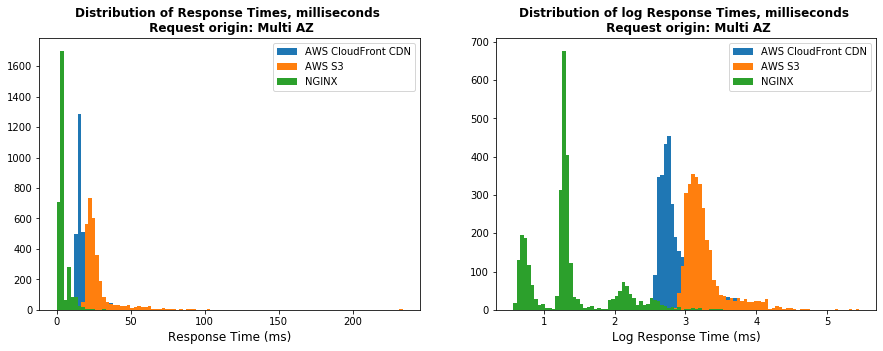

Mean response times (ms): 18.586894333333333 (CloudFront), 28.335949333333332 (S3), 4.898942666666667 (NGINX) 
Variance: 59.24 (CloudFront), 368.68 (S3), 346.28 (NGINX) 
N=9000


In [4]:
cdn, ln_cdn = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='CLOUDFRONT'].values)
s3, ln_s3 = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='S3'].values)
nginx, ln_nginx = zip(*df[['resp_time','ln_resp_time']].loc[df['server']=='NGINX'].values)

bins = np.linspace(0, df['resp_time'].quantile(0.999), 100) # Less outliers
ln_bins = np.linspace(df['ln_resp_time'].min(), df['ln_resp_time'].quantile(0.999), 100)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.hist(cdn, bins=bins, label='AWS CloudFront CDN')
ax1.hist(s3, bins=bins, label='AWS S3')
ax1.hist(nginx, bins=bins, label='NGINX')
ax1.set_title('Distribution of Response Times, milliseconds \n Request origin: Multi AZ', fontsize=12, fontweight='bold')
ax1.legend()
ax1.set_xlabel("Response Time (ms)", fontsize=12)

ax2.hist(ln_cdn, bins=ln_bins, label='AWS CloudFront CDN')
ax2.hist(ln_s3, bins=ln_bins, label='AWS S3')
ax2.hist(ln_nginx, bins=ln_bins, label='NGINX')
ax2.set_title('Distribution of log Response Times, milliseconds \n Request origin: Multi AZ', fontsize=12, fontweight='bold')
ax2.legend()
ax2.set_xlabel("Log Response Time (ms)", fontsize=12)

plt.savefig('./static/ec2-hist.png')
plt.show()

print(f"Mean response times (ms): {np.mean(cdn)} (CloudFront), {np.mean(s3)} (S3), {np.mean(nginx)} (NGINX) ")
print(f"Variance: {np.var(cdn):.2f} (CloudFront), {np.var(s3):.2f} (S3), {np.var(nginx):.2f} (NGINX) ")
print(f"N={df.shape[0]}")

In [21]:
# Get server dummies - s3 as base
server_dummies = pd.get_dummies(df['server']).drop('S3', axis=1)

# Get Availability Zone dummies - 1a as base
az_dummies = pd.get_dummies(df['origin'], drop_first=True)

In [22]:
df = pd.concat([df, server_dummies], axis=1)
df = pd.concat([df, az_dummies], axis=1)

In [24]:
df.rename(columns={
    "ap-southeast-1a" : "ap_southeast_1a",
    "ap-southeast-1b" : "ap_southeast_1b",
    "ap-southeast-1c" : "ap_southeast_1c"
}, inplace=True)

In [26]:
results = smf.ols("ln_resp_time ~ NGINX + CLOUDFRONT + ap_southeast_1b + ap_southeast_1c ", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_resp_time   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     9675.
Date:                Tue, 15 Oct 2019   Prob (F-statistic):               0.00
Time:                        14:52:46   Log-Likelihood:                -4527.4
No. Observations:                9000   AIC:                             9065.
Df Residuals:                    8995   BIC:                             9100.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1861      0.009    3

## Discussion

Interesting stuff. When we conduct the same experiment using EC2 instances launched in different availability zones, the estimates show a different result. The requests to the CDN have a faster response time as compared to S3 this time round. In fact, using a CDN over S3 is associated with a $100(e^{-0.4016}-1)=-33.1$ percent decrease in response times.

Still, Nginx outperforms the other two delivery methods. The estimates suggest that using an Nginx server is associated with a $100(e^{-1.9215}-1)=-85.4$ percent decrease in response times!

What is a possible cause of the differences in results from the first run? Looking at the distributions, we can see that the Nginx responses have 3 distinct peaks, and this is expected as our requests come from 3 availability zones, whereas the Nginx server is deployed in one  (ap-southeast-1a). And we can expect the fastest group of responses (first peak in the graph) correspond to the availability zone that the server was deployed in. This is confirmed by a quick inspection of the data.

In [50]:
print(f"Mean response time for NGINX (ap-southeast-1a): \
    {df['resp_time'].loc[(df['server']=='NGINX') & (df['origin']=='ap-southeast-1a')].mean()}")
print(f"Mean response time for NGINX (ap-southeast-1b): \
    {df['resp_time'].loc[(df['server']=='NGINX') & (df['origin']=='ap-southeast-1b')].mean()}")
print(f"Mean response time for NGINX (ap-southeast-1c): \
    {df['resp_time'].loc[(df['server']=='NGINX') & (df['origin']=='ap-southeast-1c')].mean()}")

Mean response time for NGINX (ap-southeast-1a):     3.531129
Mean response time for NGINX (ap-southeast-1b):     6.646465
Mean response time for NGINX (ap-southeast-1c):     4.519234


Herein lies another potential bias to the results. As we conduct the experiment from EC2 servers, we are essentially making requests that are very close to the CDN and S3 infrastructure. Since CloudFront and S3 both store copies of the file redundantly across all three AZs, we may be making the requests directly from the same data center the files are stored. 

To eliminate this bias and improve our design, we will run this experiment using a VPN instead to simulate requests from different locations in the region in the next notebook. 